<a href="https://colab.research.google.com/github/Magferat/Clustering-with-Neural-Networks/blob/main/DEC_CSE425.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
import pandas as pd

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.06MB/s]


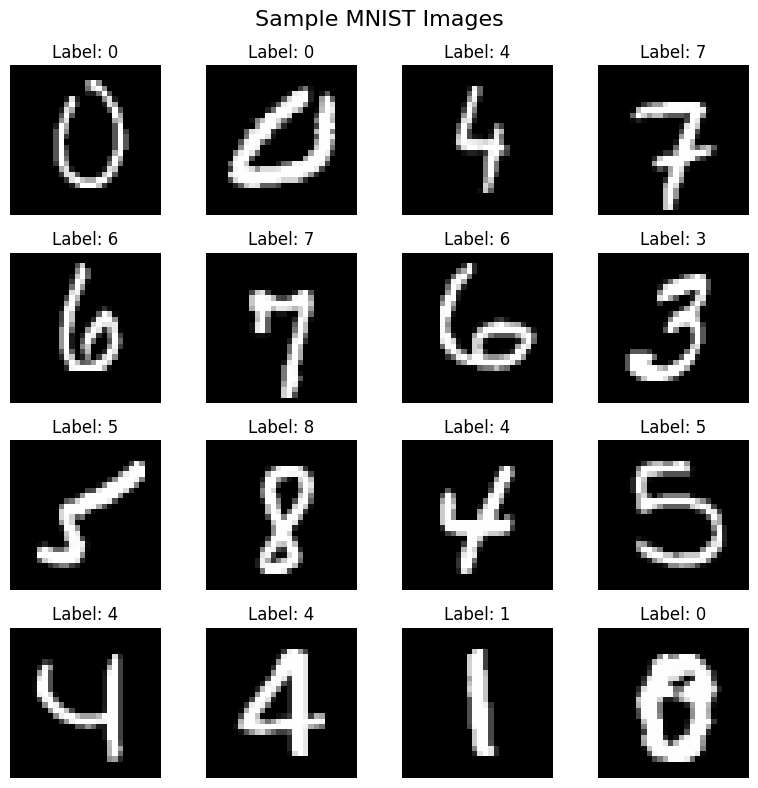

In [3]:


# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the first 16 images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Sample MNIST Images", fontsize=16)
plt.tight_layout()
plt.show()


<ipython-input-4-e5b6255af81d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Digit", data=label_df, palette="viridis")


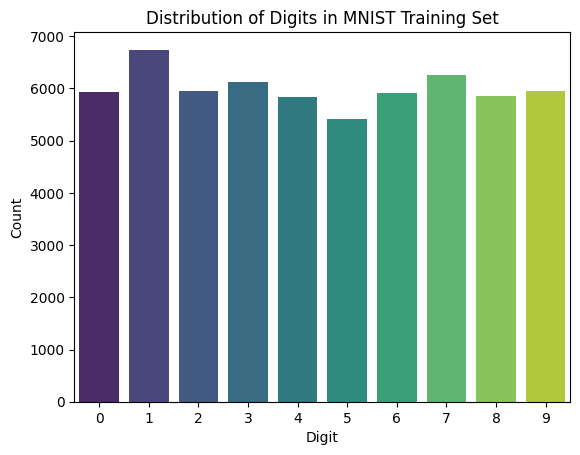

In [4]:


# Collect all labels from the full dataset
all_labels = [label for _, label in train_dataset]

# Create a bar plot of label distribution
label_df = pd.DataFrame(all_labels, columns=["Digit"])
sns.countplot(x="Digit", data=label_df, palette="viridis")
plt.title("Distribution of Digits in MNIST Training Set")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # 28x28
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon


In [6]:
ae = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

# Pretrain loop
for epoch in range(20):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"AE Epoch {epoch+1}"):
        imgs = imgs.to(device)
        _, recons = ae(imgs)
        loss = criterion(recons, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


AE Epoch 1: 100%|██████████| 235/235 [00:13<00:00, 17.14it/s]


Epoch 1, Loss: 0.2026


AE Epoch 2: 100%|██████████| 235/235 [00:13<00:00, 17.81it/s]


Epoch 2, Loss: 0.1066


AE Epoch 3: 100%|██████████| 235/235 [00:13<00:00, 17.63it/s]


Epoch 3, Loss: 0.0912


AE Epoch 4: 100%|██████████| 235/235 [00:12<00:00, 18.18it/s]


Epoch 4, Loss: 0.0826


AE Epoch 5: 100%|██████████| 235/235 [00:12<00:00, 18.34it/s]


Epoch 5, Loss: 0.0771


AE Epoch 6: 100%|██████████| 235/235 [00:12<00:00, 18.43it/s]


Epoch 6, Loss: 0.0732


AE Epoch 7: 100%|██████████| 235/235 [00:12<00:00, 18.96it/s]


Epoch 7, Loss: 0.0702


AE Epoch 8: 100%|██████████| 235/235 [00:12<00:00, 18.97it/s]


Epoch 8, Loss: 0.0679


AE Epoch 9: 100%|██████████| 235/235 [00:12<00:00, 18.92it/s]


Epoch 9, Loss: 0.0661


AE Epoch 10: 100%|██████████| 235/235 [00:12<00:00, 19.13it/s]


Epoch 10, Loss: 0.0644


AE Epoch 11: 100%|██████████| 235/235 [00:12<00:00, 19.00it/s]


Epoch 11, Loss: 0.0631


AE Epoch 12: 100%|██████████| 235/235 [00:12<00:00, 19.18it/s]


Epoch 12, Loss: 0.0619


AE Epoch 13: 100%|██████████| 235/235 [00:12<00:00, 19.13it/s]


Epoch 13, Loss: 0.0609


AE Epoch 14: 100%|██████████| 235/235 [00:12<00:00, 18.80it/s]


Epoch 14, Loss: 0.0600


AE Epoch 15: 100%|██████████| 235/235 [00:12<00:00, 18.94it/s]


Epoch 15, Loss: 0.0592


AE Epoch 16: 100%|██████████| 235/235 [00:12<00:00, 18.60it/s]


Epoch 16, Loss: 0.0586


AE Epoch 17: 100%|██████████| 235/235 [00:12<00:00, 18.74it/s]


Epoch 17, Loss: 0.0579


AE Epoch 18: 100%|██████████| 235/235 [00:12<00:00, 18.83it/s]


Epoch 18, Loss: 0.0573


AE Epoch 19: 100%|██████████| 235/235 [00:12<00:00, 18.92it/s]


Epoch 19, Loss: 0.0567


AE Epoch 20: 100%|██████████| 235/235 [00:12<00:00, 18.16it/s]

Epoch 20, Loss: 0.0563


In [7]:
def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

class DEC:
    def __init__(self, model, n_clusters=10, alpha=1.0):
        self.model = model
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(
            torch.randn(n_clusters, 10, dtype=torch.float32).to(device)
        )

    def soft_assign(self, z):
        z = z.float()
        dist = torch.cdist(z, self.cluster_centers, p=2) ** 2
        num = (1.0 + dist / self.alpha) ** ((self.alpha + 1.0) / -2)
        return (num.T / num.sum(1)).T  # shape: (batch, n_clusters)

    def kl_loss(self, q, p):
        return torch.nn.functional.kl_div(q.log(), p, reduction='batchmean')

# Step 1: Extract embeddings
ae.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        all_embeddings.append(z.cpu())
        all_labels.append(labels)

embeddings = torch.cat(all_embeddings)
labels = torch.cat(all_labels)

# Step 2: Init cluster centers with KMeans
kmeans = KMeans(n_clusters=10, n_init=20)
y_pred = kmeans.fit_predict(embeddings)
dec = DEC(ae, 10)
dec.cluster_centers.data = torch.tensor(
    kmeans.cluster_centers_, dtype=torch.float32, device=device
)

# Step 3: DEC training
optimizer = optim.Adam(
    [{'params': ae.encoder.parameters()}, {'params': dec.cluster_centers}], lr=1e-3
)

for epoch in range(20):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"DEC Epoch {epoch+1}"):
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        q = dec.soft_assign(z)
        p = target_distribution(q.detach())
        loss = dec.kl_loss(q, p)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[DEC] Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


DEC Epoch 1: 100%|██████████| 235/235 [00:12<00:00, 18.43it/s]


[DEC] Epoch 1, Loss: 0.2193


DEC Epoch 2: 100%|██████████| 235/235 [00:12<00:00, 18.75it/s]


[DEC] Epoch 2, Loss: 0.1931


DEC Epoch 3: 100%|██████████| 235/235 [00:12<00:00, 18.83it/s]


[DEC] Epoch 3, Loss: 0.1821


DEC Epoch 4: 100%|██████████| 235/235 [00:12<00:00, 18.86it/s]


[DEC] Epoch 4, Loss: 0.1739


DEC Epoch 5: 100%|██████████| 235/235 [00:12<00:00, 19.34it/s]


[DEC] Epoch 5, Loss: 0.1685


DEC Epoch 6: 100%|██████████| 235/235 [00:12<00:00, 18.71it/s]


[DEC] Epoch 6, Loss: 0.1633


DEC Epoch 7: 100%|██████████| 235/235 [00:12<00:00, 19.03it/s]


[DEC] Epoch 7, Loss: 0.1591


DEC Epoch 8: 100%|██████████| 235/235 [00:12<00:00, 19.34it/s]


[DEC] Epoch 8, Loss: 0.1550


DEC Epoch 9: 100%|██████████| 235/235 [00:12<00:00, 19.08it/s]


[DEC] Epoch 9, Loss: 0.1516


DEC Epoch 10: 100%|██████████| 235/235 [00:12<00:00, 19.48it/s]


[DEC] Epoch 10, Loss: 0.1490


DEC Epoch 11: 100%|██████████| 235/235 [00:12<00:00, 19.44it/s]


[DEC] Epoch 11, Loss: 0.1455


DEC Epoch 12: 100%|██████████| 235/235 [00:12<00:00, 19.47it/s]


[DEC] Epoch 12, Loss: 0.1431


DEC Epoch 13: 100%|██████████| 235/235 [00:12<00:00, 19.56it/s]


[DEC] Epoch 13, Loss: 0.1404


DEC Epoch 14: 100%|██████████| 235/235 [00:12<00:00, 18.86it/s]


[DEC] Epoch 14, Loss: 0.1384


DEC Epoch 15: 100%|██████████| 235/235 [00:12<00:00, 18.96it/s]


[DEC] Epoch 15, Loss: 0.1360


DEC Epoch 16: 100%|██████████| 235/235 [00:12<00:00, 19.08it/s]


[DEC] Epoch 16, Loss: 0.1339


DEC Epoch 17: 100%|██████████| 235/235 [00:12<00:00, 18.95it/s]


[DEC] Epoch 17, Loss: 0.1318


DEC Epoch 18: 100%|██████████| 235/235 [00:12<00:00, 18.97it/s]


[DEC] Epoch 18, Loss: 0.1301


DEC Epoch 19: 100%|██████████| 235/235 [00:12<00:00, 18.84it/s]


[DEC] Epoch 19, Loss: 0.1282


DEC Epoch 20: 100%|██████████| 235/235 [00:12<00:00, 19.35it/s]

[DEC] Epoch 20, Loss: 0.1264


In [8]:

ae.eval()
with torch.no_grad():
    all_z = []
    for imgs, _ in train_loader:
        z, _ = ae(imgs.to(device))
        all_z.append(z.cpu())
    z = torch.cat(all_z).numpy()

# KMeans clustering
kmeans = KMeans(n_clusters=10, n_init=20).fit(z)
labels_pred = kmeans.labels_

# Evaluation metrics
sil = silhouette_score(z, labels_pred)
db = davies_bouldin_score(z, labels_pred)
chi = calinski_harabasz_score(z, labels_pred)

print(f"Silhouette Score:         {sil:.4f}")
print(f"Davies-Bouldin Index:     {db:.4f}")
print(f"Calinski-Harabasz Index:  {chi:.4f}")


Silhouette Score:         0.7153
Davies-Bouldin Index:     0.3816
Calinski-Harabasz Index:  125713.7266


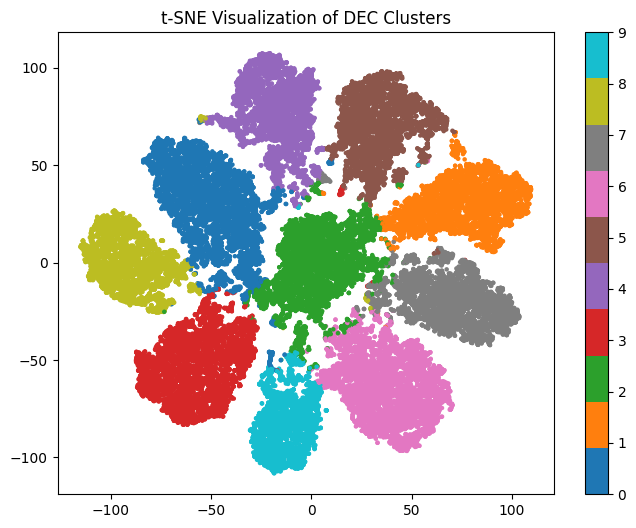

In [9]:
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z)

plt.figure(figsize=(8,6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=kmeans.labels_, cmap='tab10', s=5)
plt.title("t-SNE Visualization of DEC Clusters")
plt.colorbar()
plt.show()


In [10]:
import pickle

with open("dec_results.pkl", "wb") as f:
    pickle.dump({
        "embeddings": z,
        "labels": labels.numpy(),
        "preds": kmeans.labels_,
        "silhouette": sil,
        "db_score": db
    }, f)
torch.save(ae.state_dict(), "autoencoder_mnist.pth")
